# **Vegetable Image Recognition**

## **Background**

Vegetables are an essential component of a healthy and balanced diet. They are rich in vitamins, minerals, and dietary fiber, which are essential for maintaining good health and preventing chronic diseases. In addition to their health benefits, vegetables also play an essential role in sustainable food systems. They require fewer resources, such as land, water, and energy, compared to animal-based foods.

Therefore, there is an increasing demand for healthy diets that are rich in vegetables. People are becoming more conscious about  the impact of their food choices on their health and the environment. Hense we aim to develop a model that can accurately identify different types of vegetables based on their images.

The application of this model is vast. For instance, it can be used in vegetable recognition for offline/online shopping, where users can take a picture of the vegetable they want to buy at the market and receive information about its name, market price, storage methods, nutritional content, and related recipes. For people who have language barriers or travel to foreign countries, it can be challenging to navigate local supermarkets and identify the types of vegetables they need for their diet. In such situations, the model can be a valuable tool to help these individuals identify and purchase the vegetables they need by simply taking a picture of the vegetable.

## **Dataset**

**Original Source**: University of Science and Technology of China

**Link of dataset**: https://paperswithcode.com/dataset/vegfru

It contains 150 categories of vegetables and 150 categories of fruits. We have uploaded all of the 150 categories of vegetables to our google drive, each category contains at least 200 images.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Based on our business goal, doing vegetable recognition for online/offline shopping, we decided to recognize only top 30 popular vegetables among all 150 categories. Another benefit of doing this is that it can significantly reduce training time. We determined the top 30 popular vegetable names and store them into a list.

Then we create the path for our training, validation, and test set respectively. Since deep learning models take a long time to train, we decided to just use half of the data, divide it into training, validation and test sets, and select the best final model. We make sure that each category contains at least 100 images.

In [ ]:
import os
import random
from shutil import copyfile

# Top 30 popular vegetable names
top_30_veg = ['tomato', 'broccoli', 'onion', 'garlic', 'carrot', 'cucumber', 'celery', 'lettuce', 'eggplant', 'pumpkin',
              'spinach', 'sweet_potato', 'zucchini', 'asparagus', 'radish', 'cabbage',  'bok choy', 'cauliflower', 'potato',
              'okra', 'corn', 'mushroom', 'yam', 'bean', 'turnip', 'ginger', 'seaweed', 'kale', 'leek', 'fennel', 'artichoke',
              'taro', 'watercress', 'collard greens', 'kohlrabi', 'mustard greens', 'parsnip', 'rutabaga',
              'tomatillo', 'celeriac', 'horseradish', 'beets', 'chives', 'dill','bamboo_shoot','Chinese_pumpkin','Chinese_yam',
              'Chinese_mallow','Chinese_cabbage']

# Set up directories
file_path = '/content/drive/Shareddrives/BA865/code and dataset/vegfru/'
data_dir = file_path+'veg200_images'
train_dir = file_path+'veg_data/half_train'
val_dir = file_path+'veg_data/half_val'
test_dir = file_path+'veg_data/half_test'
datasets=[train_dir,val_dir,test_dir]


### Data Preprocessing

In the following block, we will set up the training set, validation set and test set for our top30 vegetable classes. We will use the ratio 8:1:1 for these three datasets. We ramdomly shuffle the data from those 30 classes and make a copy of the images to the new datasets.


#### Train, validation and test sets split

We plan to set a validation set instead of using cross validation because our dataset is relatively large, we have enough data for training and validation. Also, cross validation takes too long to train on large dataset.

**Please don't run this block as the datasets have already been created!!!**

In [ ]:

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Set up train-test split ratios
# We divide all ratio by 2 because we will only use half of the data
train_ratio = 0.8/2
val_ratio = 0.1/2
test_ratio = 0.1/2

# Iterate through each label folder
for label_folder in os.listdir(data_dir):
    if label_folder in top_30_veg:

        label_path = os.path.join(data_dir, label_folder)

        # Create a list of image files for this label
        image_files = []
        for image_file in os.listdir(label_path):
            if image_file.endswith('.jpg'):
                image_files.append(image_file)

        # Shuffle the image files to randomize the order
        random.shuffle(image_files)

        # Split the image files into training, validation, and testing sets
        train_size = int(len(image_files) * train_ratio)
        val_size = int(len(image_files) * val_ratio)
        test_size = int(len(image_files) * test_ratio)

        train_files = image_files[:train_size]
        val_files = image_files[train_size:train_size+val_size]
        test_files = image_files[train_size+val_size:train_size+val_size+test_size]

        # Copy the training, validation, and testing files to their respective directories
        for image_file in train_files:
            src = os.path.join(label_path, image_file)
            dst = os.path.join(train_dir, label_folder, image_file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            copyfile(src, dst)

        for image_file in val_files:
            src = os.path.join(label_path, image_file)
            dst = os.path.join(val_dir, label_folder, image_file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            copyfile(src, dst)

        for image_file in test_files:
            src = os.path.join(label_path, image_file)
            dst = os.path.join(test_dir, label_folder, image_file)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            copyfile(src, dst)
    else:
        continue

#### Checking whether there are corrupted images

We use the image.decode_image() function in tensorflow to find some corrupted images that will influence our model training. This is similar to handle null values in some numerical datasets.

*If you run this, there is no corrupted images because we have already removed all corrupted images.


In [ ]:
import os
import tensorflow as tf

def is_image(file):
    return file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))

def check_images(directory):
    corrupted_images = []

    for root, _, files in os.walk(directory):
        for file in files:
            if is_image(file):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'rb') as f:
                        image_bytes = f.read()
                        image_tensor = tf.image.decode_image(image_bytes)
                except Exception as e:
                    print(f"Corrupted image: {file_path} - Error: {e}")
                    corrupted_images.append(file_path)

    return corrupted_images

for dataset in datasets:
    corrupted_images = check_images(dataset)
    print(f"Found {len(corrupted_images)} corrupted images.")

Corrupted image: /content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data/half_train/potato/v_14_07_0028.jpg - Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage]
Found 1 corrupted images.
Found 0 corrupted images.
Found 0 corrupted images.


### Descriptive Analysis

In the following block, we will go through all training, validation and test dataset, and visualize the data distribution for each class.

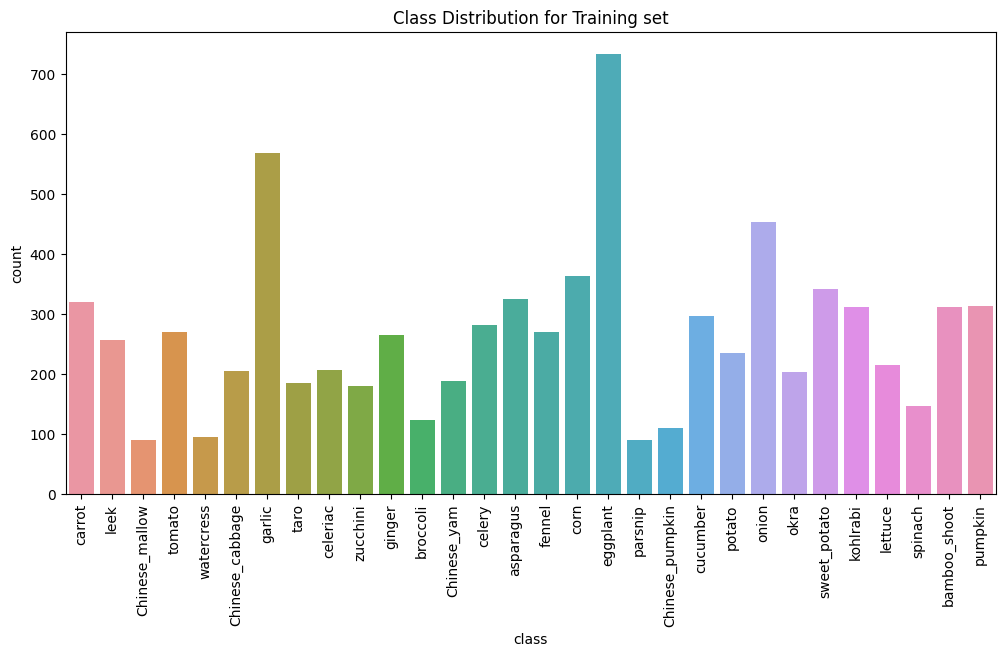

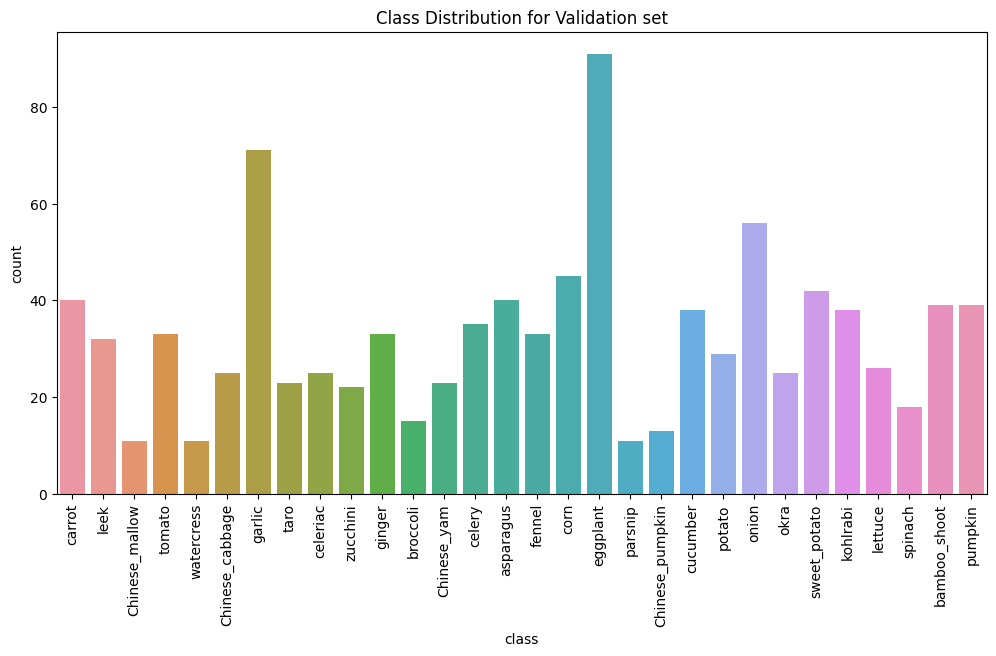

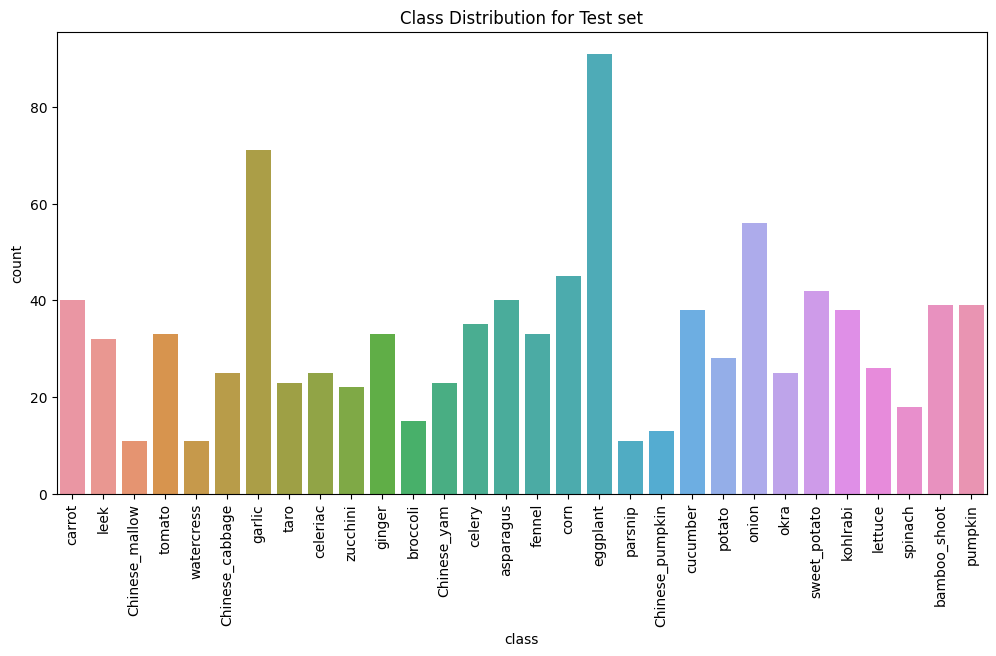

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_image_properties(image_folder):
    image_properties = []

    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    with Image.open(img_path) as img:
                        width, height = img.size
                        image_properties.append({
                            'class': class_folder,
                            'width': width,
                            'height': height,
                            'aspect_ratio': width / height
                        })

    return pd.DataFrame(image_properties)

train_properties_df = extract_image_properties(train_dir)
val_properties_df = extract_image_properties(val_dir)
test_properties_df = extract_image_properties(test_dir)

# Class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=train_properties_df, x='class')
plt.title('Class Distribution for Training set')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=val_properties_df, x='class')
plt.title('Class Distribution for Validation set')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=test_properties_df, x='class')
plt.title('Class Distribution for Test set')
plt.xticks(rotation=90)
plt.show()

The distributions of traing, validation and test set are similar since they are copied from the original dataset using 8:1:1 ratio. It's not a balanced dataset, but there are at least 100 images for each class to guarantee the performance of our model. In the next step, we may use some class weights parameters or gain more data to solve the unbalanced issue.



## **Model Building**

### Dense layers

For the model with only dense layers, we have 32 images in each batch. Our input shape is (180, 180, 3). We have 4 hidden layers. The number of neurons in the hidden layers starts from 512. We choose this number because it can capture more complex features as well as avoid overfitting. In all of the hidden layers, we use ReLU activation function since it is computationally efficient. Also it can prevent the vanishing gradient problem. The activation function in our output layer is  softmax, which is often used in classification models. It assigns a probability to each class.

We use RMSprop as our optimizer. It is an adaptive learning rate optimization which works well with ReLU. We choose categorical_crossentropy loss function since we have changed our target variables to one-hot encoded vectors. The metrics of our model is the accuracy model. It is calculated as the number of correctly classified instances divided by the total number of instances.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    batch_size=32,
    class_mode='categorical'
)

# Load the validation data
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(180,180),
    batch_size=32,
    class_mode='categorical'
)

# Load the test data
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(180,180),
    batch_size=32,
    class_mode='categorical'
)


Found 7947 images belonging to 30 classes.
Found 982 images belonging to 30 classes.
Found 981 images belonging to 30 classes.


In [ ]:
# Build a dense layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Assuming you have already loaded your train_dataset, validation_dataset, and test_dataset
# as shown in your initial code snippet.

input_shape = (180, 180, 3)  # Assuming RGB images with 180x180 pixels
num_classes = 30

# Create a feedforward neural network (MLP) model
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)



Epoch 1/10
249/249 [==============================] - 345s 1s/step - loss: 8.2406 - accuracy: 0.0769 - val_loss: 3.2966 - val_accuracy: 0.0937
Epoch 2/10
249/249 [==============================] - 329s 1s/step - loss: 3.3298 - accuracy: 0.0919 - val_loss: 3.2792 - val_accuracy: 0.0927
Epoch 3/10
249/249 [==============================] - 316s 1s/step - loss: 3.3071 - accuracy: 0.0926 - val_loss: 3.2806 - val_accuracy: 0.0927
Epoch 4/10
249/249 [==============================] - 312s 1s/step - loss: 3.2865 - accuracy: 0.0930 - val_loss: 3.2788 - val_accuracy: 0.0927
Epoch 5/10
249/249 [==============================] - 317s 1s/step - loss: 3.2909 - accuracy: 0.0934 - val_loss: 3.2785 - val_accuracy: 0.0967
Epoch 6/10
249/249 [==============================] - 342s 1s/step - loss: 3.2997 - accuracy: 0.0934 - val_loss: 3.2780 - val_accuracy: 0.0937
Epoch 7/10
249/249 [==============================] - 359s 1s/step - loss: 3.3189 - accuracy: 0.0924 - val_loss: 3.2786 - val_accuracy: 0.0927

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

31/31 [==============================] - 26s 832ms/step - loss: 3.2783 - accuracy: 0.0938
Test accuracy: 0.09378185868263245


The test accuracy of this model is only 9.38%. It is very low, so we gave up this model and tried the CNN model below.

### CNN

In this section, we build three CNN models in total with different pretrained model.
- Model1 with pretrained model VGG16
- Model2 with pretrained model ResNet50
- Model3 with pretrained model InceptionV3

In [ ]:
# Load tha data
from tensorflow.keras.utils import image_dataset_from_directory
base_dir = '/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data/'

train_dataset = image_dataset_from_directory(
    base_dir + "/half_train/",
    image_size=(180, 180),
    label_mode="categorical",
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    base_dir + "/half_val/",
    image_size=(180, 180),
    label_mode="categorical",
    batch_size=32)

test_dataset = image_dataset_from_directory(
    base_dir + "/half_test/",
    image_size=(180, 180),
    label_mode="categorical",
    batch_size=32)

Found 7949 files belonging to 30 classes.
Found 982 files belonging to 30 classes.
Found 982 files belonging to 30 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 30)


In [ ]:
num_class = 30

#### Model1 with pretrained model VGG16

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
## Use this to preprocess data, mapping from pictures to numerical feature maps
conv_base1 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base1.trainable = False # The convolutional layers won't be updatable; we just build on them using Functional API.

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base1(x)

for size in [32, 64, 128]: ## Num of filters
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_class, activation="softmax")(x)

model1 = keras.Model(inputs, outputs)
model1.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 180, 180, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                              

In [ ]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_with_data_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model1.fit(
    train_dataset, # We are back to working with our original training dataset.
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
249/249 [==============================] - 1795s 7s/step - loss: 8.8897 - accuracy: 0.1576 - val_loss: 2.9675 - val_accuracy: 0.4175
Epoch 2/40
249/249 [==============================] - 28s 111ms/step - loss: 3.0711 - accuracy: 0.3845 - val_loss: 1.7292 - val_accuracy: 0.5967
Epoch 3/40
249/249 [==============================] - 28s 112ms/step - loss: 1.8881 - accuracy: 0.5267 - val_loss: 1.4873 - val_accuracy: 0.6538
Epoch 4/40
249/249 [==============================] - 28s 110ms/step - loss: 1.4799 - accuracy: 0.6010 - val_loss: 1.1862 - val_accuracy: 0.6976
Epoch 5/40
249/249 [==============================] - 29s 113ms/step - loss: 1.2313 - accuracy: 0.6545 - val_loss: 1.1608 - val_accuracy: 0.7189
Epoch 6/40
249/249 [==============================] - 28s 111ms/step - loss: 1.0699 - accuracy: 0.6978 - val_loss: 1.0262 - val_accuracy: 0.7363
Epoch 7/40
249/249 [==============================] - 28s 111ms/step - loss: 1.0130 - accuracy: 0.7125 - val_loss: 1.0130 - val_acc

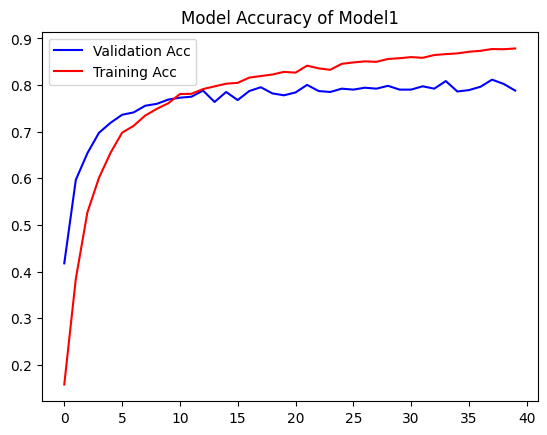

In [ ]:
plt.title('Model Accuracy of Model1')
plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

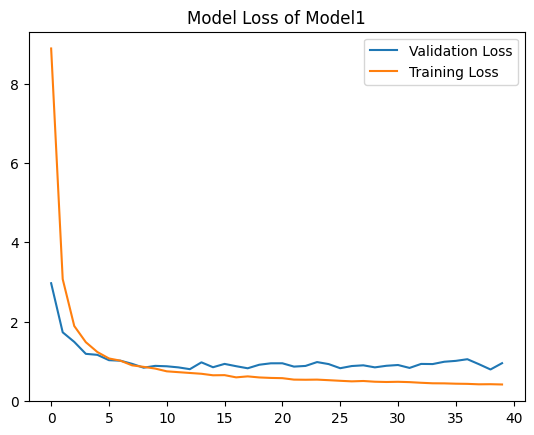

In [ ]:
plt.title('Model Loss of Model1')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.plot(history.history['loss'],label='Training Loss')
plt.legend()
plt.show()

In [ ]:
test_model1 = keras.models.load_model("fine_tuning_with_data_augmentation1.keras")
test_loss, test_acc = test_model1.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

31/31 [==============================] - 216s 5s/step - loss: 0.8342 - accuracy: 0.7984
Test accuracy: 0.7983706593513489


First, for model1, we tried the pre-trained model with VGG16. We set the VGG16 model to be not trainable, and we added a set of convolutional layers on top of the pretrained model.

- The convolutional layer consists of three blocks, each with a different number of filters (32, 64, and 128). Each block contains two convolutional layers followed by a max pooling layer. The residual connection is added between the input and output of each block, which can prevent the vanishing gradients.
- After the convolutional layers, the output is flattened and passed through a fully connected layer with a dropout rate of 0.5 to reduce overfitting.
- Output layer: It consists of a dense layer with the number of units, which is equal to the number of classes, and a softmax activation function to generate class probabilities.
- Finally, the model is compiled with the categorical cross-entropy loss function, RMSprop optimizer, and accuracy metric.

Based on the accuracy performance of this model, we found there is a little bit of overfitting here. And the test accuracy can reach 80%.

#### Model2 with pretrained model ResNet50

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers


In [ ]:
conv_base2 = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

conv_base2.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
conv_base2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base2(x)


for size in [32, 64, 128]: ## Num of filters
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_class, activation="softmax")(x) ## Num of classes


model2 = keras.Model(inputs, outputs)
model2.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 180, 180, 3)  0          ['sequential_1[0][0]']           
 icingOpLambda)                                                                                   
                                                                                            

In [ ]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_with_data_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model2.fit(
    train_dataset, # Note we are back to working with our original training dataset.
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
249/249 [==============================] - 34s 106ms/step - loss: 3.8692 - accuracy: 0.4170 - val_loss: 2.3364 - val_accuracy: 0.6650
Epoch 2/30
249/249 [==============================] - 24s 97ms/step - loss: 2.0066 - accuracy: 0.6423 - val_loss: 1.4223 - val_accuracy: 0.7749
Epoch 3/30
249/249 [==============================] - 25s 97ms/step - loss: 1.4272 - accuracy: 0.7210 - val_loss: 1.2562 - val_accuracy: 0.7597
Epoch 4/30
249/249 [==============================] - 23s 93ms/step - loss: 1.1690 - accuracy: 0.7602 - val_loss: 1.3709 - val_accuracy: 0.7301
Epoch 5/30
249/249 [==============================] - 24s 96ms/step - loss: 1.0092 - accuracy: 0.7815 - val_loss: 0.9990 - val_accuracy: 0.7994
Epoch 6/30
249/249 [==============================] - 24s 93ms/step - loss: 0.8885 - accuracy: 0.8102 - val_loss: 1.0231 - val_accuracy: 0.8035
Epoch 7/30
249/249 [==============================] - 24s 95ms/step - loss: 0.8392 - accuracy: 0.8172 - val_loss: 0.8197 - val_accuracy

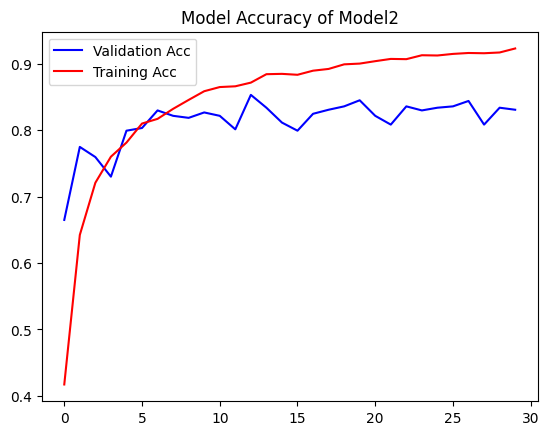

In [ ]:
plt.title('Model Accuracy of Model2')
plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

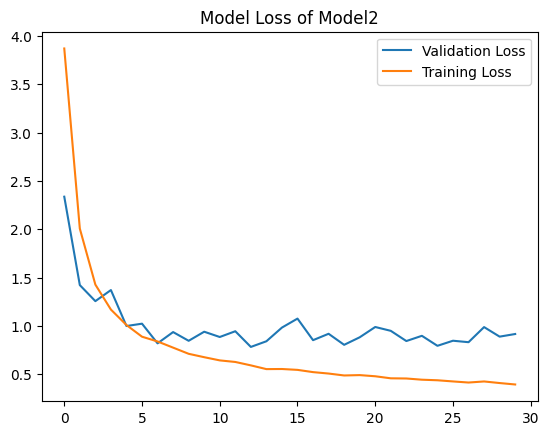

In [ ]:
plt.title('Model Loss of Model2')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.plot(history.history['loss'],label='Training Loss')
plt.legend()
plt.show()

In [ ]:
test_model2 = keras.models.load_model("fine_tuning_with_data_augmentation2.keras")
test_loss, test_acc = test_model2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

31/31 [==============================] - 4s 70ms/step - loss: 0.7588 - accuracy: 0.8554
Test accuracy: 0.8553971648216248


For model2, we use ResNet50 as our pre-trained model. To solve overfitting problem, we add a L2 regularization in one CNN layer and increase the drop out rate. Finally, we can achieve 83.40% test accuracy.

#### Model3 with pretrained model InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model

In [ ]:
# Load the pre-trained InceptionV3 model
conv_base3 = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_222 (Conv2D)            (None, 89, 89, 32)   864         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_211 (Batch  (None, 89, 89, 32)  96          ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
# Load the pre-trained InceptionV3 model
conv_base3 = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# Create the data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Build the new model on top of the pre-trained model
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base3(x)

# Unfreeze some of the layers in the pre-trained model

for layer in conv_base3.layers:
    if layer.name.startswith('mixed8'):  # unfreeze layers from this layer onwards
        layer.trainable = True
    else:
        layer.trainable = False

# Add new layers to the model
for size in [32, 64, 128]: ## Num of filters
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_class, kernel_regularizer=regularizers.l2(0.01), activation="softmax")(x)

model3 = keras.Model(inputs, outputs)

optimizer = RMSprop(learning_rate=0.0001, momentum=0.9)

model3.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])

In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 180, 180, 3)  0           ['input_8[0][0]']                
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 180, 180, 3)  0          ['sequential_3[0][0]']           
 icingOpLambda)                                                                                   
                                                                                            

In [ ]:
%%time
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_with_data_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")]

history = model3.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
249/249 [==============================] - 17s 40ms/step - loss: 3.5093 - accuracy: 0.3658 - val_loss: 1.9840 - val_accuracy: 0.5866
Epoch 2/50
249/249 [==============================] - 9s 34ms/step - loss: 2.1459 - accuracy: 0.5422 - val_loss: 1.4463 - val_accuracy: 0.6792
Epoch 3/50
249/249 [==============================] - 9s 35ms/step - loss: 1.6583 - accuracy: 0.6154 - val_loss: 1.2421 - val_accuracy: 0.6986
Epoch 4/50
249/249 [==============================] - 9s 35ms/step - loss: 1.3531 - accuracy: 0.6639 - val_loss: 1.1647 - val_accuracy: 0.7189
Epoch 5/50
249/249 [==============================] - 9s 35ms/step - loss: 1.1266 - accuracy: 0.7073 - val_loss: 1.0878 - val_accuracy: 0.7220
Epoch 6/50
249/249 [==============================] - 9s 35ms/step - loss: 1.0325 - accuracy: 0.7276 - val_loss: 1.0517 - val_accuracy: 0.7138
Epoch 7/50
249/249 [==============================] - 9s 36ms/step - loss: 0.9327 - accuracy: 0.7453 - val_loss: 0.9829 - val_accuracy: 0.727

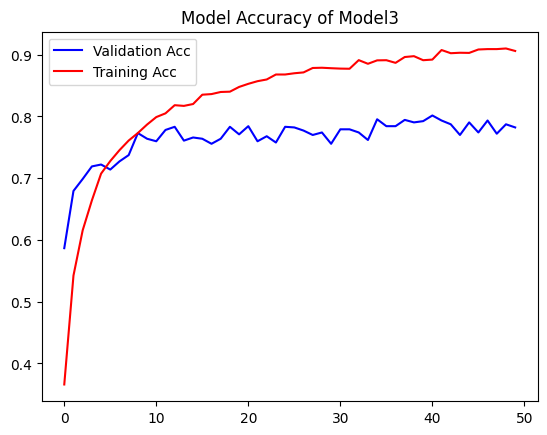

In [ ]:
plt.title('Model Accuracy of Model3')
plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

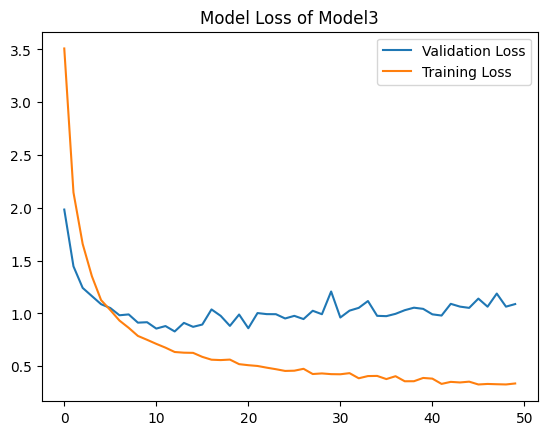

In [ ]:
plt.title('Model Loss of Model3')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.plot(history.history['loss'],label='Training Loss')
plt.legend()
plt.show()

In [ ]:
test_model3 = keras.models.load_model("fine_tuning_with_data_augmentation3.keras")
test_loss, test_acc = test_model3.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

31/31 [==============================] - 2s 28ms/step - loss: 0.7457 - accuracy: 0.8147
Test accuracy: 0.8146639466285706


For model3, we use InceptionV3 as our pre-trained model. This time, I did not set the whole pre-trained model to be not trainable. I unfreeze all layers starting from the "mixed7" block. The reason why I choose the "mixed7" block in InceptionV3 is because it is located roughly in the middle of the network. Now we can fine-tune the model for both low-level and high-level features. I tried to change the freezing layer, and mixed7 is the best choice with a better model performance. Therefore, by fine-tuning only the higher layers, we can leverage the pre-trained lower layers, while the mode can still adapt to the specific dataset that we are using.

After the pertain model,  we add new layers, including several convolutional layers that we did before. And also applied hyperparameter tuning for these layers. Finally, it can achieve 81.47% of test accuracy.


#### LIME Image Explainer

We implemented LIME Image Explainer on our best model, which is the CNN with pretrained model ResNet50.

In [ ]:
# Generate predictions for the test dataset
test_predictions = test_model2.predict(test_dataset)

# Get the predicted labels for each image
predicted_labels = np.argmax(test_predictions, axis=1)

# Get the true labels for each image
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Get the filenames of the test dataset
test_filenames = test_dataset.file_paths

# Find which images were predicted correctly
correctly_predicted_indices = np.where(predicted_labels == true_labels)[0]

# Get the filenames of the correctly predicted images
correctly_predicted_filenames = [test_filenames[i] for i in correctly_predicted_indices]

# Print the filenames of the correctly predicted images
print("Filenames of correctly predicted images:")
for filename in correctly_predicted_filenames:
    print(filename)

31/31 [==============================] - 3s 67ms/step
Filenames of correctly predicted images:
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/pumpkin/v_09_10_0422.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/celeriac/v_13_05_0407.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/Chinese_cabbage/v_05_01_0216.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/garlic/v_01_03_0735.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/asparagus/v_12_01_0090.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/taro/v_14_09_0462.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/okra/v_12_09_0288.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half_test/sweet_potato/v_14_08_0461.jpg
/content/drive/Shareddrives/BA865/code and dataset/vegfru/veg_data//half

Here it shows all the images' paths that are predicted correctly based on our best model. This can be used for futher LIME model visualization or further analysis on whether the majority of the false predictions made fall into specific categories.

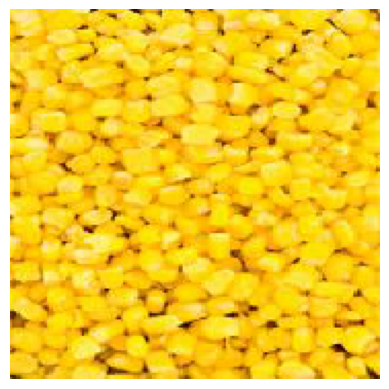

In [ ]:
import matplotlib.pyplot as plt
try:
  import lime
  from lime import lime_image
except ImportError as error:
  !pip install lime
  import lime
  from lime import lime_image

import random
import numpy as np

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

file_path = filename
cat_name = file_path.split('/')[-2]
file_tensor = get_img_array(file_path, target_size=(180, 180)).astype('double')
file_tensor = np.divide(file_tensor,255)


plt.axis("off")
plt.imshow(file_tensor[0])#.astype("uint8"))
plt.show()

In [ ]:
try:
  from skimage.segmentation import mark_boundaries
except ImportError as error:
  !pip install skimage
  from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Instantiate our LIME explainer.
explainer = lime_image.LimeImageExplainer()

# Now use it to 'explain' the first test image.
explanation = explainer.explain_instance(file_tensor[0], model2.predict, num_samples=1000, top_labels=2, hide_color=1)

print(f'The most probable label for this image is as follows: {explanation.top_labels}.')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
The most probable label for this image is as follows: [24, 28].


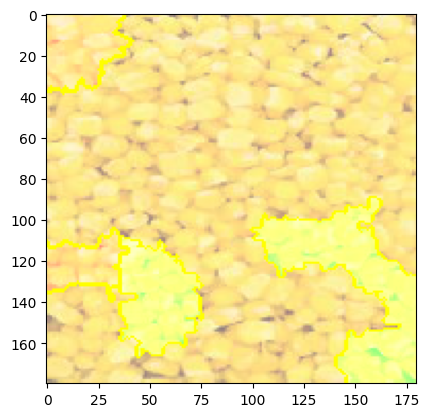

In [ ]:
# positive_only = True means we only display pixels that contributed positively to the respective label.
# Notice for most labels, the pixel contributions are basically 0.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)
# Add a plot for the associated label
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

The green part corresponds to the positive contribution of each feature, meaning that an increase in the feature value leads to a higher probability of the target class. The red part corresponds to the negative contribution of each feature, meaning that an increase in the feature value leads to a lower probability of the target class.

## **Conclusion**

After conducting experiments with three different models and performing hyperparameter tuning, we observed that all three models exhibited similar levels of overfitting. Hence, we decided to choose the best model based on its test accuracy.

Model1 has test accuracy at 76.88%.

Model2 has test accuracy at 83.40%.

Model3 has test accuracy at 81.47%.

Therefore, we selected Model2 as our final model, which is a CNN model with ResNet pretrained model with the highest test accuracy among the three models.

## **Next step**

The existing CNN-based image classification model can recognize a single vegetable in an image with high accuracy. We can improve the performance by the following ways:

1. Increase the size of the training dataset: The model can be trained on a larger dataset of vegetable images to capture more variations and patterns in the images.
2. Check whether the majority of the false predictions made by our model fall into specific categories: If the accuracy of our model on different classes is significantly different, we will reweigh the model to address the class imbalance. By giving higher weight to the minority classes and lower weight to the majority class, the model can pay equal attention to all classes during training.
3. Use hyperparameter optimization techniques such as grid search to find better hyperparameter combinations.
4. Incorporate attention mechanisms: Attention mechanisms can be used to selectively focus on important regions of the image, which can help the model to better capture the relevant features and improve its accuracy.

On the other hand, our model can only identify one kind of vegetables in a single image. To address this limitation, we can extend the existing model by incorporating object detection algorithms. We hope to develop an image recognition system capable of identifying multiple vegetables in a single image.

To be specific, we can extend the model by the following steps:
1. Collect and annotate a dataset of images that contain multiple vegetables.
2. Train an object detection model such as YOLO, Faster R-CNN, or Mask R-CNN on the annotated dataset to detect and locate the vegetables in the image.
3. For each detected vegetable, extract its corresponding ROI (region of interest) from the original image.
4. Use the existing CNN-based image classification model to classify each ROI into its corresponding vegetable category.
5. Repeat steps 3-4 for all the detected vegetables in the image.
6. Output the final classification results for each vegetable.

Once the model has been trained and deployed, users can provide it with a photo of the inside of their refrigerator. The model will then tell them the types of vegetables present and provide relevant nutritional information and recipe recommendations based on those vegetables. We aim to build a model that can make it easy for people to identify the vegetables in their refrigerator and use that information to make healthier, more informed meal choices.